In [17]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
import  matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_absolute_percentage_error
import random
import torch
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=521)

In [18]:
train= pd.read_excel('../dataset/pre_train.xlsx')
test= pd.read_excel('../dataset/pre_test.xlsx')

ind=[i for i in train.columns][1:-1]
#1  离群点删除
def opt(opt_rate,df,threshold):
    AQindex=[]
    train=df
    threshold_num=threshold*len(df)
    for inx in ind:
        max=train.loc[:, inx].max()
        min=train.loc[:, inx].min()
        diff=max-min
        diffmin=min+opt_rate*diff
        diffmax=min+(1-opt_rate)*diff
        minlist=train[train[inx] < diffmin].index.values.tolist()
        maxlist=train[train[inx] > diffmax].index.values.tolist()

        if len(minlist) <= threshold_num:
            # print(f'min{inx}')
            # print(len(minlist))
            for minindex in train[train[inx] < diffmin].index.values.tolist():
                AQindex.append(minindex)

        if len(maxlist) <= threshold_num:
            # print(f'max{inx}')
            # print(len(maxlist))
            for maxindex in train[train[inx] > diffmax].index.values.tolist():
                AQindex.append(maxindex)
    AQindex=list(set(AQindex))
    # print(AQindex)
    AQindex=sorted(AQindex)
    return AQindex
optindex=opt(opt_rate=0.1,df=train,threshold=0.015)
train=train.drop(index=optindex).reset_index(drop=True)

data = pd.concat([train,test]).reset_index(drop=True)

#2  时间特征
def add_datetime_feats(df):
    df['time'] = pd.to_datetime(df['time'])
    # df['year']=df['year'].dt.year  # 获取年
    # df['month']=df['month'].dt.month  # 获取月
    # df['day'] = df['time'].dt.day       # 获取天
    df['hour'] = df['time'].dt.hour
    df['minute']=df['time'].dt.minute  # 获取分钟
    df['weekday']=df['time'].dt.weekday
    df['ts']=df['hour']*60+df['minute']  # 判断是一年的第几个季度
    return df
data= add_datetime_feats(data)

#3 去除率指标
data['Var_COD']=data['WI_COD']-data['WO_COD']
data['Var_AN']=(data['WI_AN']-data['WO_AN'])
data['Var_TN']=(data['WI_TN']-data['WO_TN'])
data['Var_AR_DO']=data['AR_WODO']-data['AR_WIDO']
data['Var_AR_AN']=(data['WI_AN']-data['AR_AN'])


data['RM_COD']=(data['WI_COD']-data['WO_COD'])/data['WI_COD']
data['RM_AN']=(data['WI_AN']-data['WO_AN'])/data['WI_AN']
data['RM_TN']=(data['WI_TN']-data['WO_TN'])/data['WI_TN']
data['RM_AR_DO']=(data['AR_WODO']-data['AR_WIDO'])/data['AR_WODO']
data['RM_AR_AN']=(data['WI_AN']-data['AR_AN'])/data['WI_AN']



#4 时序上的滚动特征
roll_cols = ['WI_F',
 'WI_T',
 'WI_COD',
 'WI_TN',
 'WI_AN',
 'WO_F',
 'WO_T',
 'WO_COD',
 'WO_TN',
 'WO_AN',
 'AR_MLSS',
 'AR_AN',
 'AR_NN',
 'AR_WIDO',
 'AR_WODO',
 'AR_F']
for i in [j for j in range(1, 6)] + [10, 15, 20, 30, 60, 120]:
    # data[[ii+f'_delta_{i}' for ii in roll_cols]] = data[roll_cols].diff(periods=i)
    data[[ii+f'_mean_{i}' for ii in roll_cols]] = data[roll_cols].rolling(i, min_periods=1).mean()


#根据方差只保留save_rate的特征数量
pd.set_option("display.max_columns", 100)
save_rate = 0.8
data = data[data.describe().T.sort_values(by="std", ascending=False, inplace=False).iloc[: int(len(data.columns)*save_rate)].index.tolist()]

train = data.iloc[:train.shape[0]].reset_index(drop=True)
test = data.iloc[train.shape[0]:].reset_index(drop=True)

X_columns = [col for col in train.columns if col not in ['time','AQ','hour','minute','weekday','ts']]
Y_columns =['AQ']

x_train=train[X_columns]
y_train=train[Y_columns]
x_test=test[X_columns]
y_test=test[Y_columns]

In [19]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_features=128,max_depth=32,min_samples_split=2000,min_samples_leaf=200,max_leaf_nodes=100)
model.fit(x_train,y_train)


DecisionTreeRegressor(max_depth=32, max_features=128, max_leaf_nodes=100,
                      min_samples_leaf=200, min_samples_split=2000)

In [20]:
joblib.dump(model, './mpkl/m3_dt_.pkl')
model= joblib.load('./mpkl/m3_dt_.pkl')

In [22]:
test_index=test.index
y_test_pred=model.predict(x_test)
y_test_pred=pd.DataFrame(columns=['AQ'],data=y_test_pred)

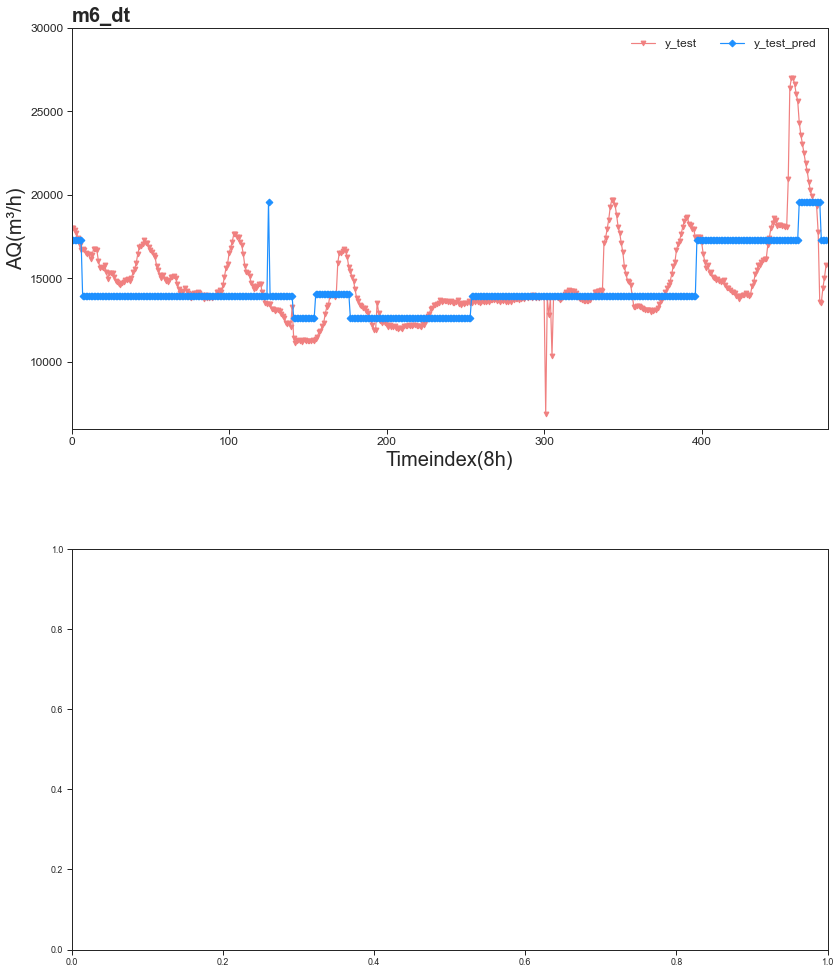

In [23]:
import seaborn as sns
sns.set(context='paper', style='ticks')

fig,axes=plt.subplots(2,1,figsize=(15,16))
ax1=axes[0]
ax2=axes[1]
fig.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)


x=test_index
y1=y_test['AQ']
y2=y_test_pred['AQ']
lns1=ax1.plot(x,y1,label='y_test',marker='v',markevery=1, color='lightcoral')
lns2=ax1.plot(x,y2,label='y_test_pred',marker='D',markevery=1, color='dodgerblue')
ax1.tick_params(labelsize=12)
ax1.set_xlim(0,480,1)
ax1.set_ylim(6000,30000, 5000)
ax1.set_xlabel('Timeindex(8h)',size=20)
ax1.set_ylabel('AQ(m³/h)',size=20)
ax1.set_title('m6_dt',size=20,fontweight='bold',loc='left')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,fontsize=12,ncol=2,frameon=False)

In [24]:
frame=pd.DataFrame()

frame['ytest']=y_test_pred
frame.to_excel('../secondgoaldata/m3_dt.xlsx')